In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Sun/ML Shock/Final project/

/content/drive/MyDrive/Sun/ML Shock/Final project


# Convolutional Neural Networks


In [3]:
import sys
# sys.path.insert(0,"C:/Users/Amy/Desktop/Green_Git/eegClassification/utils")
sys.path.insert(0,"/content/drive/MyDrive/Sun/ML Shock/Final project/")

In [4]:
# Import libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage

from CustomDatasetNPYb2 import CustomDataset
from torch.utils.data import DataLoader

# from scipy.special import kl_div

# import os

In [5]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


---
## Load the Data

In [6]:
# Load (train or test) data from csv file
# path = "C:/Users/Amy/Desktop/Green_Git/eegClassification/sample_data/"
# path_df = "C:/Users/Amy/Desktop/Green_Git/eegClassification/files/"
# scaler_path = "C:/Users/Amy/Desktop/Green_Git/eegClassification/models/scalers/"

path = "./data_prep/"
path_df = "./"
scaler_path = "./data/"
path_model = "./model_efficientnetb2_spec__lr_001_v2.pt"


In [7]:
# Type of input data
data_type = "spec" # "eeg_raw" #"eeg_spec"  #
# Type of mscale
scaler_type = "min_max" #"standard" #
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64

In [8]:
if data_type == "spec":
    input_shape = (3,288,288) #(4,299,100)
elif data_type == "eeg_spec":
    input_shape = (20,129,43)
elif data_type == "eeg_raw":
    input_shape = (20,9800)

In [9]:
train_data = CustomDataset(data_path = path+'train/', N_items = 101)
train_loader = DataLoader(train_data, batch_size=1, shuffle=False, num_workers=num_workers)

In [10]:
valid_data = CustomDataset(data_path = path+'valid/', N_items = 35)
valid_loader = DataLoader(valid_data, batch_size=1, shuffle=False, num_workers=num_workers)

In [11]:
# specify the image classes
classes = [
        "seizure_vote",
        "lpd_vote",
        "gpd_vote",
        "lrda_vote",
        "grda_vote",
        "other_vote",
    ]
N_classes = len(classes)
classes

['seizure_vote',
 'lpd_vote',
 'gpd_vote',
 'lrda_vote',
 'grda_vote',
 'other_vote']

In [12]:
x_transform = lambda x, y, z: (
    x[0, :],
    y[0, :],
    z[0, :],
)

In [13]:
%%time
# obtain one batch of training images
dataiter = iter(train_loader)
data, labels, votes = next(dataiter)
data, labels, votes = x_transform(data, labels, votes)


CPU times: user 132 ms, sys: 247 ms, total: 379 ms
Wall time: 464 ms


In [14]:
labels.shape, votes.shape, data.shape

(torch.Size([64]), torch.Size([64, 6]), torch.Size([64, 3, 288, 288]))

In [15]:
np.min(data.numpy().reshape(batch_size, -1)), np.max(data.numpy().reshape(batch_size, -1))

(-2.117904, 2.64)

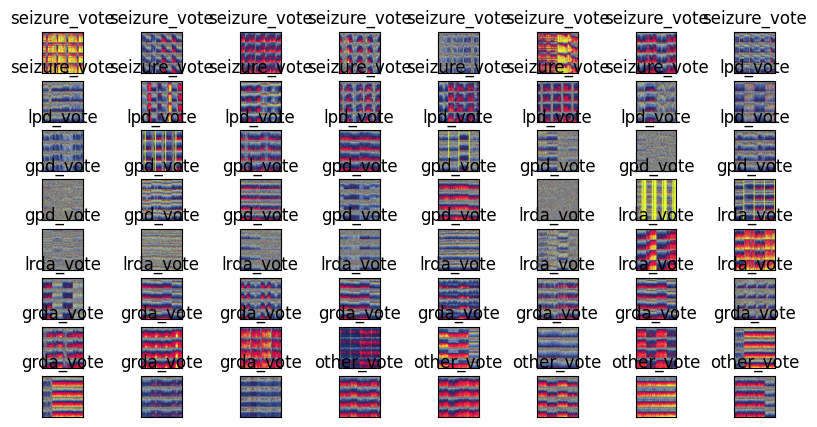

In [16]:
# sort the labels in accending order
labels, indices = torch.sort(labels)
data = data[indices, :, :]
votes = votes[indices, :]

# image show data
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))
# display 20 images
for idx in np.arange(data.shape[0]):
    # if classes[label[idx]] != "seizure_vote":
    #     continue
    ax = fig.add_subplot(8, 8, idx + 1, xticks=[], yticks=[])
    # show black and white images
    # ax.imshow(data[idx, :, :])  # , cmap="gray"
    img = ToPILImage()(data[idx, :, :])
    ax.imshow(img)
    ax.set_title(classes[labels[idx]])

plt.show()


## Define the Network Architecture


In [17]:
# class that will be used to fine tune resent model
from torchvision import models

model = models.efficientnet_b2(pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [18]:
num_features = model.classifier[-1].in_features
print('Number of features from pre-trained model', num_features)

num_parameters = sum(p.numel() for p in model.parameters())
print('Number of parameters in the model', num_parameters)

Number of features from pre-trained model 1408
Number of parameters in the model 9109994


In [33]:
# define the CNN architecture
class TransNet(nn.Module):
    def __init__(self):
        super(TransNet, self).__init__()

        self.model = models.efficientnet_b0(pretrained=True)
        # freeze all model parameters
        for param in self.model.parameters():
            param.requires_grad = False

        # # remove the last layer
        self.model.classifier[-1] = nn.Identity()

        # a layer to go some shape (4,299,100) to (3,299,100)
        # self.conv1 = nn.Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        # replace first layer with new layer
        # self.model.features[0] = self.conv1

        # add new layer
        self.fc = nn.Linear(1280, N_classes) #num_features


    def forward(self, x):
        x = self.model(x)
        x = F.log_softmax(self.fc(x), dim=1)

        return x

In [34]:
# create a complete CNN
model = TransNet()
# path_model_old = "./model_efficientnet_finetuned_spec_v1.pt"
# model.load_state_dict(torch.load(path_model_old))
model

TransNet(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activa

In [35]:
num_features = model.fc.in_features
print('Number of features from pre-trained model', num_features)

num_parameters = sum(p.numel() for p in model.parameters())
print('Number of parameters in the model', num_parameters)

Number of features from pre-trained model 1280
Number of parameters in the model 4015234


In [36]:
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

### Specify [Loss Function](https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html#torch.nn.KLDivLoss) and [Optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)


In [37]:
criterion = nn.KLDivLoss(reduction="batchmean",log_target= True)
optimizer = optim.Adam(model.parameters(), lr=0.001)

---
## Train the Network


In [41]:
import gc
from tqdm import tqdm
# number of epochs to train the model
n_epochs = 30
max_samples = 500

valid_loss_min = np.Inf # track change in validation loss

print('Epoch: \tTraining Loss:  \tValidation Loss:')
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    # count = 0

    for data, label, votes in tqdm(train_loader):
        # if count >= max_samples:
        #     break

        data, label, votes = x_transform(data, label, votes)
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
           data, label, votes = data.cuda(), label.cuda(), votes.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)

        # loss
        loss = criterion(output.float(), F.log_softmax(votes.float(), dim=1))
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

        # count +=1


    torch.cuda.empty_cache()
    ######################
    # validate the model #
    ######################
    model.eval()
    # count = 0
    for data, label, votes in tqdm(valid_loader):
        # if count >= max_samples*0.1:
        #     break

        data, label, votes = x_transform(data, label, votes)
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, label, votes = data.cuda(), label.cuda(), votes.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output.float(), F.log_softmax(votes.float(), dim=1))
        # update average validation loss
        valid_loss += loss.item()*data.size(0)

        # count +=1


    torch.cuda.empty_cache()
    # calculate average losses
    train_loss = train_loss/len(train_loader)#/batch_size#/max_samples#
    valid_loss = valid_loss/len(valid_loader)#/batch_size#/max_samples/0.1#/

    # print training/validation statistics
    print('{}; \t{:.6f}; \t{:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        # print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        # valid_loss_min,
        # valid_loss))
        torch.save(model.state_dict(), path_model)
        valid_loss_min = valid_loss

    gc.collect()

Epoch: 	Training Loss:  	Validation Loss:


100%|██████████| 35/35 [01:18<00:00,  2.25s/it]


1; 	53.610821; 	50.636035


100%|██████████| 35/35 [00:17<00:00,  1.97it/s]


2; 	46.291834; 	49.674921


100%|██████████| 35/35 [00:18<00:00,  1.92it/s]


3; 	44.242499; 	49.149624


100%|██████████| 35/35 [00:17<00:00,  1.97it/s]


4; 	42.809453; 	48.958442


100%|██████████| 35/35 [00:17<00:00,  1.96it/s]


5; 	41.548275; 	48.988715


100%|██████████| 35/35 [00:18<00:00,  1.89it/s]


6; 	41.131497; 	49.107855


100%|██████████| 35/35 [00:17<00:00,  1.96it/s]


7; 	40.949379; 	49.250263


100%|██████████| 35/35 [00:17<00:00,  1.95it/s]


8; 	40.665619; 	48.809500


100%|██████████| 35/35 [00:17<00:00,  1.96it/s]


9; 	40.101532; 	49.080429


100%|██████████| 35/35 [00:17<00:00,  1.96it/s]


10; 	39.837978; 	49.180534


100%|██████████| 35/35 [00:18<00:00,  1.87it/s]


11; 	39.394736; 	49.444594


100%|██████████| 35/35 [00:18<00:00,  1.87it/s]


12; 	39.611368; 	49.071377


100%|██████████| 35/35 [00:18<00:00,  1.89it/s]


13; 	39.087963; 	49.396232


100%|██████████| 35/35 [00:18<00:00,  1.90it/s]


14; 	39.455443; 	49.258141


100%|██████████| 35/35 [00:18<00:00,  1.89it/s]


15; 	38.838257; 	49.343907


100%|██████████| 35/35 [00:18<00:00,  1.89it/s]


16; 	39.070613; 	49.486117


100%|██████████| 35/35 [00:18<00:00,  1.93it/s]


17; 	39.100362; 	49.032561


100%|██████████| 35/35 [00:13<00:00,  2.57it/s]


18; 	38.810680; 	49.584065


100%|██████████| 35/35 [00:14<00:00,  2.48it/s]


19; 	38.896220; 	49.761122


100%|██████████| 35/35 [00:13<00:00,  2.59it/s]


20; 	38.795008; 	49.330820


100%|██████████| 35/35 [00:13<00:00,  2.59it/s]


21; 	38.357405; 	49.664114


100%|██████████| 35/35 [00:13<00:00,  2.61it/s]


22; 	38.432863; 	49.780612


100%|██████████| 35/35 [00:13<00:00,  2.57it/s]


23; 	38.306676; 	49.826475


100%|██████████| 35/35 [00:13<00:00,  2.59it/s]


24; 	38.567730; 	49.605977


100%|██████████| 35/35 [00:13<00:00,  2.58it/s]


25; 	38.441176; 	49.883777


100%|██████████| 35/35 [00:13<00:00,  2.59it/s]


26; 	38.747544; 	50.011387


100%|██████████| 35/35 [00:13<00:00,  2.57it/s]


27; 	38.254848; 	49.950646


100%|██████████| 35/35 [00:13<00:00,  2.60it/s]


28; 	38.449852; 	49.911878


100%|██████████| 35/35 [00:13<00:00,  2.62it/s]


29; 	37.996277; 	50.062723


100%|██████████| 35/35 [00:13<00:00,  2.62it/s]

30; 	38.458001; 	49.973985


###  Load the Model with the Lowest Validation Loss

In [42]:
model.load_state_dict(torch.load(path_model))

<All keys matched successfully>

---
## Test the Trained Network

Test your trained model on previously unseen data! A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

In [43]:
# data_dir, data_type, info_test = load_data(path, path_df, data_type, "test")
# data_dir, data_type, len(info_test)

In [44]:
# test_data = CustomDataset(data_dir, data_type, info_test, transform=transform)
# test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [45]:
test_data = CustomDataset(data_path = path+'test/', N_items = 35)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, num_workers=num_workers)

In [46]:
# track test loss
test_loss = 0.0
test_loss_baseline = 0.0
class_correct = list(0. for i in range(N_classes))
class_total = list(0. for i in range(N_classes))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval()

cm_y_pred = []
cm_y_true = []
# iterate over test data
# count = 0
for data, target, votes in tqdm(test_loader):
    # if count >= max_samples*0.1:
    #   break
    # count+=1

    data, target, votes = x_transform(data, target, votes)
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target, votes = data.cuda(), target.cuda(), votes.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output.float(), F.log_softmax(votes.float(), dim=1))
    # dummy is a tensor filled with 1/6 of shape [64,6]
    dummy = torch.ones(data.size(0), N_classes).to(device)
    dummy = dummy/N_classes
    loss_baseline = criterion(output.float(), F.log_softmax(dummy, dim=1))
    # update test loss
    test_loss += loss.item()*data.size(0)
    test_loss_baseline += loss_baseline.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

        cm_y_pred.append(pred[i].item())
        cm_y_true.append(target.data[i].item())

# average test loss
print()
test_loss = test_loss/len(test_loader.dataset)#/batch_size#/max_samples/0.1#
print('Test Loss: {:.6f}\n'.format(test_loss))

test_loss_baseline = test_loss_baseline/len(test_loader.dataset)#/batch_size#/max_samples/0.1#
print('Test Loss Baseline: {:.6f}\n'.format(test_loss_baseline))


100%|██████████| 35/35 [01:19<00:00,  2.26s/it]


Test Loss: 47.464769

Test Loss Baseline: 31.046661



In [47]:
for i in range(N_classes):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Accuracy of seizure_vote: 60% (325/534)
Test Accuracy of lpd_vote: 48% (159/331)
Test Accuracy of gpd_vote: 76% (254/334)
Test Accuracy of lrda_vote: 30% (92/298)
Test Accuracy of grda_vote: 57% (198/344)
Test Accuracy of other_vote: 43% (173/399)

Test Accuracy (Overall): 53% (1201/2240)


In [48]:
# prompt: confusion matrix

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(cm_y_true, cm_y_pred)
print(confusion_matrix)


[[325  31  20  22  33 103]
 [ 23 159  38  40  25  46]
 [ 15  17 254   3  14  31]
 [ 38  35  10  92  68  55]
 [ 30  13  14  21 198  68]
 [ 62  30  26  27  81 173]]
